In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.utils import shuffle

from sklearn.manifold import TSNE

In [2]:
#defining all the required functions here
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

def cleanHTML(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanPunctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', sentence)
    return cleaned


#removing stop words
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initializing the Snowball Stemmer

final_dataset_path = '/home/monodeepdas112/Datasets/amazon-fine-food-reviews/final.sqlite'
initial_dataset_path = '/home/monodeepdas112/Datasets/amazon-fine-food-reviews/database.sqlite'

In [3]:
if os.path.isfile(final_dataset_path):
    #loading the cleaned dataset if present
    con = sqlite3.connect(final_dataset_path)
    data = pd.read_sql_query('select * from Reviews', con)
    
    with open('positive_words.pkl', 'rb') as f:
        all_positive_words = pickle.load(f)
    with open('negitive_words.pkl', 'rb') as f:
        all_negative_words = pickle.load(f)
else:
    #cleaning the dataset and making the finally cleaned dataset if the cleaned dataset is not present
    con = sqlite3.connect(initial_dataset_path)
    filtered_data = pd.read_sql_query('select * from Reviews where score != 3', con)
    
    #replacing the score column to contain only positive or negative rather than continuous range of values
    actualScore = filtered_data['Score']
    positiveNegativeScore = actualScore.map(partition)
    filtered_data['Score'] = positiveNegativeScore
    
    #data deduplication
    sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
    
    #removing some wrong data points
    data = data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
    
    #text pre-processing
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(data['Text'].values)):
        filtered_sentence=[]
        sent = cleanHTML(sent)#removing HTML tags
        for w in sent.split():
            for cleaned_words in cleanPunctuation(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower()))
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive':
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = ' '.join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
    
    #############---- storing the data into final.sqlite file ------########################
    data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    data['CleanedText']=final['CleanedText']
    
    conn = sqlite3.connect(final_dataset_path)
    c=conn.cursor()
    conn.text_factory = str
    data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    #saving the dictionaries
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month learn poem throug...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [5]:
min_data_points = 50

In [7]:
pos_data = data[data.Score=='positive'].loc[:, ['CleanedText', 'Score']]
pos_data = pos_data.sample(min_data_points)
neg_data = data[data.Score=='negative'].loc[:, ['CleanedText', 'Score']]
neg_data = neg_data.sample(min_data_points)
part_data = pos_data.append(neg_data)
part_data = shuffle(part_data)

In [8]:
part_data.head(10)

,CleanedText,Score
11754,order red cheeri cooki receiv green cheeri cou...,negative
220931,interest cup good coffe fine realli want tast ...,negative
197042,overal would nice gift unfortunat reciev mine ...,negative
55891,way sweet manag one make sure tri small pack b...,negative
235128,probabl worst coffe ever product week expir re...,negative
162879,gum burn hell mouth chew gum hour day work hel...,negative
178714,recommend coffe bean bean dark oili produc wea...,negative
148561,product use instead refin sugar everywher swee...,positive
198595,great stuff use get local whole food market st...,positive
139935,receiv multipack med garden green cat love cle...,positive


## t-SNE with Word2Vec

In [24]:
#Using the word2vec by google instead of training my own
with open('/home/monodeepdas112/Datasets/google_w2v_for_amazon.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
#getting to know the shape of the vectors
model['tri'].shape

(300,)

In [26]:
model['tri']

array([-2.05078125e-01, -1.47094727e-02, -2.01171875e-01,  1.06811523e-02,
       -6.49414062e-02, -5.81054688e-02, -2.18750000e-01, -1.52343750e-01,
       -1.50390625e-01,  2.63671875e-02,  2.33398438e-01, -3.06396484e-02,
        5.27343750e-02,  3.29971313e-04,  1.35742188e-01,  8.74023438e-02,
       -2.92968750e-01,  3.92578125e-01, -4.61425781e-02,  5.46875000e-02,
       -9.91210938e-02,  7.71484375e-02, -1.61132812e-01, -1.59179688e-01,
       -2.13623047e-02,  3.22265625e-01, -2.36328125e-01,  2.49023438e-01,
        1.65039062e-01, -3.26171875e-01, -7.47070312e-02,  2.77343750e-01,
       -1.25000000e-01,  3.19824219e-02,  1.12915039e-02,  2.25830078e-02,
       -1.00097656e-01, -1.96289062e-01,  2.46093750e-01,  1.71875000e-01,
       -9.71679688e-02,  3.88183594e-02,  1.19140625e-01,  1.68945312e-01,
       -1.77734375e-01,  8.15429688e-02,  4.41894531e-02, -2.07031250e-01,
       -4.80957031e-02,  2.73437500e-01,  1.80664062e-01,  3.08593750e-01,
        8.05664062e-03,  

In [20]:
#Averaging word2vec
sent_vector = []
list_of_sents = part_data.CleanedText.values
for sent in list_of_sents:
    sent_vec = np.zeros(300)
    cnt_words = 0
    for word in sent:
        try:
            vec = model[word]
            sent_vec += vec
            cnt_words +=1
        except:
            pass
        sent_vec /= cnt_words
        sent_vector.append(sent_vec)
print(len(sent_vector))
print(len(sent_vector[0]))

20214
300


In [18]:
#setting up t-SNE using Average Word2Vec
features = sent_vector
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

AttributeError: 'list' object has no attribute 'toarray'

## t-SNE with Bag of Words and TFIDF Vectors

In [ ]:
#Generating the Count Vectors for the cleaned Text with bi-grams and unigrams
cnt_vec = CountVectorizer(ngram_range=(1,3))
count_vectors = cnt_vec.fit_transform(part_data['CleanedText'].values)
print("the shape of out text BOW vectorizer ",count_vectors.get_shape())
print("the number of unique words ", count_vectors.get_shape()[1])

tfidf_vec = TfidfVectorizer(ngram_range=(1,3))
tfidf_vectors = tfidf_vec.fit_transform(part_data['CleanedText'].values)
print("the shape of out text TFIDF vectorizer ",count_vectors.get_shape())
print("the number of unique words ", count_vectors.get_shape()[1])

In [ ]:
#setting up t-SNE using BOW
features = count_vectors.toarray()
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

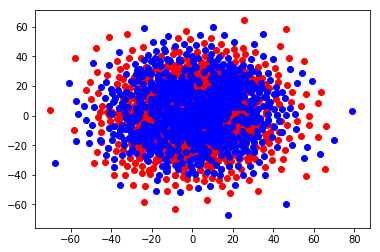

In [13]:
#setting up t-SNE using TFIDF
features = tfidf_vectors.toarray()
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

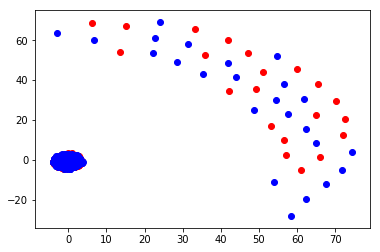

In [14]:
#setting up t-SNE using BOW
features = count_vectors.toarray()
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=5000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

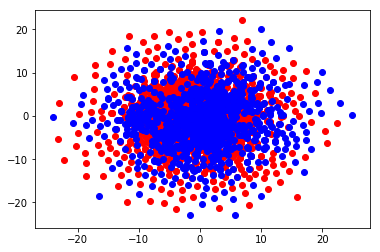

In [15]:
#setting up t-SNE using TFIDF
features = tfidf_vectors.toarray()
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=5000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

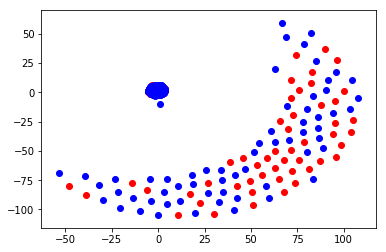

In [16]:
#setting up t-SNE using BOW
features = count_vectors.toarray()
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=10000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

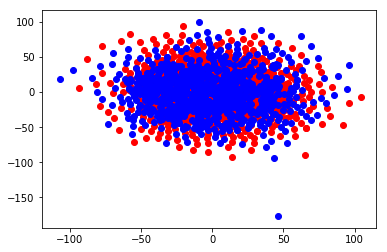

In [17]:
#setting up t-SNE using TFIDF
features = tfidf_vectors.toarray()
labels = part_data['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=10000)
tsne_data = model.fit_transform(features)

#creating a new dataframe which help in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

pos = tsne_df[tsne_df.label=='positive']
neg = tsne_df[tsne_df.label=='negative']
plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
plt.show()

## t-SNE Visualization with Word2Vec

In [1]:
with open('/home/monodeepdas112/Datasets/google_w2v_for_amazon.pkl', 'rb') as f:
    model = pickle.load(f)

NameError: name 'pickle' is not defined